written by Konrad, 16-Dec-20 - 17-Dec-20

In [26]:
import pandas as pd
import re
from os import path

In [244]:
#load TextComplexityDE dataset
df_all = pd.read_excel(path.join("data", "TextComplexityDE19.xlsx"), sheet_name=2, header=1)
df_all.columns = df_all.columns.str.lower()

In [264]:
#create columns normalized_text and character_count
def remove_numbers(string):
    return re.sub(r'\d', '', string)
def remove_punctuation(string):
    string = re.sub(r'\-', ' ', string) #I'm considering a hyphenated word separated enough to count as 2 words 
    return re.sub(r'[^\w\s]', '', string)
def remove_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def find_longest(list):
    length = 0
    for i in range(len(list)):
        if len(list[i]) > length:
            length = len(list[i])
    return length
def count_syllables(list):
    cc_pattern = re.compile("[^aeiouyäöü]{2,}")
    sentence_syllables = 0
    for word in list:
        word_syllables = 1
        current_pos = len(word) - 1
        while current_pos >= 0:
            current_character = word[current_pos]
            current_pos -= 1
            if current_character in 'aeiouyäöü':
                if current_pos <= 0:
                    break
                else:
                    current_character = word[current_pos]
                    if current_character not in 'aeiouyäöü':
                        word_syllables += 1
                    current_pos -= 1
        if cc_pattern.match(word) and len(word) > 2:
            word_syllables -= 1
        sentence_syllables += word_syllables
    return sentence_syllables
def count_polysyllables(list):
    cc_pattern = re.compile("[^aeiouyäöü]{2,}")
    polysyllables = 0
    for word in list:
        word_syllables = 1
        current_pos = len(word) - 1
        while current_pos >= 0:
            current_character = word[current_pos]
            current_pos -= 1
            if current_character in 'aeiouyäöü':
                if current_pos <= 0:
                    #current_pos = -1
                    break
                else:
                    current_character = word[current_pos]
                    if current_character not in 'aeiouyäöü':
                        word_syllables += 1
                    current_pos -= 1
        if cc_pattern.match(word) and len(word) > 2:
            word_syllables -= 1
        if word_syllables > 1:
            polysyllables += 1
    return polysyllables

def normalize_sentence(sentence, keep_numbers=False):
    normalized_sentence = sentence.str.lower()
    if not keep_numbers:
        normalized_sentence = normalized_sentence.apply(remove_numbers)
    normalized_sentence = normalized_sentence.apply(remove_punctuation)
    normalized_sentence = normalized_sentence.apply(remove_whitespace)
    return normalized_sentence

df_all['normalized_sentence'] = df_all['sentence'].str.lower()
df_all['normalized_sentence'] = df_all['normalized_sentence'].apply(remove_numbers) #the assumption here is that numbers aren't read and understood in the foreign language anyway, so they don't contribute to complexity or lack of understandability
df_all['normalized_sentence'] = df_all['normalized_sentence'].apply(remove_punctuation)
df_all['normalized_sentence'] = df_all['normalized_sentence'].apply(remove_whitespace)

df_all['word_count'] = df_all['normalized_sentence'].str.split().str.len()
df_all['syllable_count'] = df_all['normalized_sentence'].str.split().apply(count_syllables)
df_all['letter_count']  = df_all['normalized_sentence'].str.count(r'\w')
df_all['polysyllables_count'] = df_all['normalized_sentence'].str.split().apply(count_polysyllables)
df_all['flesch_score'] = 206.835 - 1.015 * df_all['word_count'] - 84.6 * (df_all['syllable_count'] * 1.0 / df_all['word_count'])
df_all['ari'] = 4.71 * (df_all['letter_count'] * 1.0 / df_all['word_count']) + .5 * df_all['word_count'] - 21.43
df_all['mean_word_length'] = (df_all['letter_count'] * 1.0) / df_all['word_count']
df_all['mean_squared_word_length'] = ((df_all['letter_count'] * 1.0) ** 2) / df_all['word_count']
df_all['max_word_length'] = df_all['normalized_sentence'].str.split().apply(find_longest)

In [275]:
string = 'beim aufblasen entsteht eine kugelform die wasserversorgung erfolgte über brunnen etwa jahre ist es her seit die sumerer das'
string2 = 'wasser laptop grüsse flasche kaiser packen'
testwort = 'donaudampfschifffahrtsgesellschaftskapitän'

for word in testwort.split():
    print(word, count_syllables([word]))

donaudampfschifffahrtsgesellschaftskapitän 10


In [247]:
print(df_all['word_count'].sum())

19718


In [248]:
df_all['rmos_r'] = df_all['mos_r'].round().astype('int64')
df_all['rmos_u'] = df_all['mos_u'].round().astype('int64')
df_all['rmos_l'] = df_all['mos_l'].round().astype('int64')

In [283]:
#R Readability/Complexity, U Understandability, L Lexical difficulty
df_all.head()

,id,sentence,article_id,article,votes_r,mos_r,std_r,votes_u,mos_u,std_u,...,multisyllabic_count,flesch_score,mean_word_length,ari,mean_squared_word_length,max_word_length,rmos_r,rmos_u,rmos_l,polysyllables_count
0,3,"Etwa 5000 Jahre ist es her, seit die Sumerer d...",1,Seifenblase,9,1.888889,0.781736,9,1.888889,0.781736,...,2,56.978462,4.307692,5.359231,241.230769,8,2,2,3,2
1,4,Als Nebenprodukt entstand damals natürlich auc...,1,Seifenblase,10,1.600000,0.699206,9,2.222222,1.301708,...,3,9.700000,6.777778,14.993333,413.444444,12,2,2,3,3
2,5,"Wegen dieser leichten Vergänglichkeit wurde ,S...",1,Seifenblase,14,4.428571,1.504572,14,4.000000,2.038099,...,4,21.565000,6.100000,17.301000,744.200000,15,4,4,4,4
3,6,Dies spiegelt sich zum Beispiel in der Redewen...,1,Seifenblase,10,3.300000,1.766981,9,2.666667,1.322876,...,6,20.348571,6.190476,18.227143,804.761905,22,3,3,3,6
4,7,In der Kunst wird spätestens seit dem Barock d...,1,Seifenblase,9,4.000000,1.870829,9,3.000000,1.936492,...,6,25.703448,6.172414,22.142069,1104.862069,14,4,3,4,6


In [284]:
df_all.sort_values(by="ari", ascending=False).head()

,id,sentence,article_id,article,votes_r,mos_r,std_r,votes_u,mos_u,std_u,...,multisyllabic_count,flesch_score,mean_word_length,ari,mean_squared_word_length,max_word_length,rmos_r,rmos_u,rmos_l,polysyllables_count
296,344,Steigende Durchschnittstemperaturen verschiebe...,9,Folgen der globalen Erwärmung,15,2.600000,1.454058,15,1.933333,1.437591,...,2,-102.800000,13.200000,43.242000,871.200000,25,3,2,3,2
287,335,Globale Erwärmung ist der beobachtete und prog...,9,Folgen der globalen Erwärmung,12,5.500000,1.732051,12,4.583333,1.729862,...,23,-52.873208,8.056604,43.016604,3440.169811,23,6,5,5,23
433,493,Während die Historische Klimatologie vielfach ...,12,Klimageschichte,9,5.555556,1.589899,9,5.333333,1.802776,...,21,-58.800000,8.666667,41.890000,3380.000000,20,6,5,5,21
391,447,Während der globale Temperaturanstieg in der e...,11,Gletscherschwund seit 1850,15,4.133333,2.065591,15,3.200000,1.780851,...,19,-44.270000,7.851064,39.048511,2897.042553,17,4,3,4,19
859,972,Die Vorbereitungen zur endlichen Verwirklichun...,22,Geschichte der Europäischen Union,8,5.625000,0.916125,9,4.333333,1.581139,...,17,-19.776379,6.362069,37.535345,2347.603448,18,6,4,5,17


In [251]:
df_wikipedia = df_all[df_all['article_id'] < 24]
df_leichte = df_all[df_all['article_id'] > 23]

print('Sentences sourced from Wikipedia:', df_wikipedia['id'].size)
print('Sentences sourced from Leichte Sprache:', df_leichte['id'].size)

Sentences sourced from Wikipedia: 900
Sentences sourced from Leichte Sprache: 100


sentences rated by score:
1    111
2    257
3    268
4    260
5     83
6     21
Name: rmos_r, dtype: int64


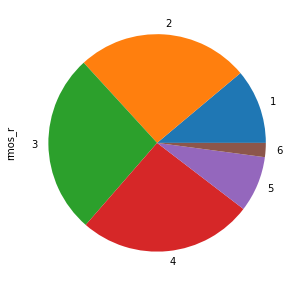

In [252]:
score_counts_r_all = df_all['rmos_r'].value_counts().sort_index()
print("sentences rated by score:")
print(score_counts_r_all)
plot = score_counts_r_all.plot.pie(subplots=True, figsize=(5, 5)) 

In [253]:
print('wikipedia:')
score_counts_r_wikipedia = df_wikipedia['rmos_r'].value_counts().sort_index()
print(score_counts_r_wikipedia)
#plot = score_counts_r_wikipedia.plot.pie(subplots=True, figsize=(5, 5)) 

print('\nleichte sprache:')
score_counts_r_leichte = df_leichte['rmos_r'].value_counts().sort_index()
print(score_counts_r_leichte)
#plot = score_counts_r_leichte.plot.pie(subplots=True, figsize=(5, 5)) 

wikipedia:
1     32
2    237
3    267
4    260
5     83
6     21
Name: rmos_r, dtype: int64

leichte sprache:
1    79
2    20
3     1
Name: rmos_r, dtype: int64


Among the 900 sentences sourced from Wikipedia, there are few that scored a 1 or a 6 in complexity and none(!) that scored a 7.
The 100 sentences sourced from Leichte Sprache are dominated by 1 scores.

In [254]:
print('median complexity score for all sentences:', df_all['mos_r'].median())
print('median complexity score for wikipedia sentences:', df_wikipedia['mos_r'].median())
print('median complexity score for leichte sentences:', df_leichte['mos_r'].median())
print()

print('median understandability score for all sentences:', df_all['mos_u'].median())
print('median understandability score for wikipedia sentences:', df_wikipedia['mos_u'].median())
print('median understandability score for leichte sentences:', df_leichte['mos_u'].median())
print()

print('median lexical difficulty score for all sentences:', df_all['mos_l'].median())
print('median lexical difficulty score for wikipedia sentences:', df_wikipedia['mos_l'].median())
print('median lexical difficulty score for leichte sentences:', df_leichte['mos_l'].median())

median complexity score for all sentences: 3.1
median complexity score for wikipedia sentences: 3.25
median complexity score for leichte sentences: 1.0

median understandability score for all sentences: 2.8819444445
median understandability score for wikipedia sentences: 3.0
median understandability score for leichte sentences: 1.0

median lexical difficulty score for all sentences: 3.4365079365
median lexical difficulty score for wikipedia sentences: 3.6
median lexical difficulty score for leichte sentences: 1.0


In [255]:
import matplotlib.pyplot as plt

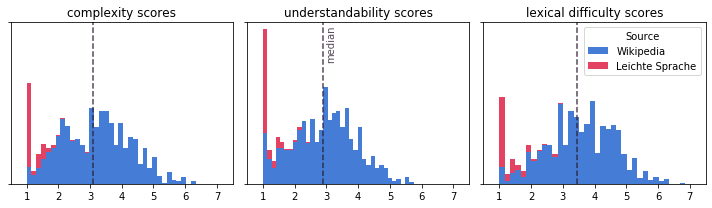

In [256]:
fig = plt.figure(figsize = (10, 3))

plt.subplot(131)
plot_colors = ["#457cd6", "#e34262"]
plt.title(r'complexity scores')
plt.hist([df_wikipedia['mos_r'], df_leichte['mos_r']], 35, stacked=True, density = True, color=plot_colors)
plt.xticks(range(1, 8))
plt.xlim([0.5, 7.5])
plt.ylim([0.0, 0.82]) 
plt.yticks([0.0, 0.82], ['', ''])
#meanx = df_all['mos_r'].mean()
medianx = df_all['mos_r'].median()
#plt.axvline(meanx, color='#6d8c32', linestyle='dashdot', alpha=.8)
plt.axvline(medianx, color='#2c1b2e', linestyle='--', alpha=.8)

plt.subplot(132)
plot_colors = ["#457cd6", "#e34262"]
plt.title(r'understandability scores')
plt.hist([df_wikipedia['mos_u'], df_leichte['mos_u']], 35, stacked=True, density = True, color=plot_colors)
plt.xticks(range(1, 8))
plt.xlim([0.5, 7.5])
plt.ylim([0.0, 0.82]) 
plt.yticks([0.0, 0.82], ['', ''])
medianx = df_all['mos_u'].median()
plt.axvline(medianx, color='#2c1b2e', linestyle='--', alpha=.8)
plt.text(medianx + .1, .63, 'median', rotation=90, color='#2c1b2e', alpha=.8)

plt.subplot(133)
plot_colors = ["#457cd6", "#e34262"]
plt.title(r'lexical difficulty scores')
plt.hist([df_wikipedia['mos_l'], df_leichte['mos_l']], 35, stacked=True, density = True, color=plot_colors, label=["Wikipedia", "Leichte Sprache"])
plt.legend(loc="upper right", title="Source")
plt.xticks(range(1, 8))
plt.xlim([0.5, 7.5])
plt.ylim([0.0, 0.82]) 
plt.yticks([0.0, 0.82], ['', ''])
medianx = df_all['mos_l'].median()
plt.axvline(medianx, color='#2c1b2e', linestyle='--', alpha=.8)

plt.tight_layout()

In [231]:
import scipy.stats

In [293]:
x_col = 'ari' #try word_count	letter_count	mean_word_length	mean_squared_word_length	max_word_length   syllable_count   ari
y_col = 'mos_r'

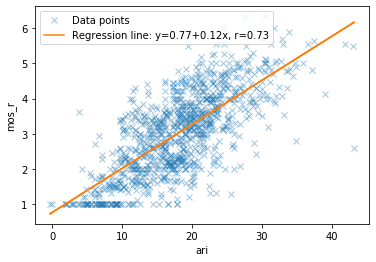

In [294]:
x = df_all[x_col]
y = df_all[y_col]

slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='x', alpha=.43, label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.legend(facecolor='white')
plt.show()